## Install Kaggle and video dataset

In [4]:
!pip install -q kaggle
!kaggle datasets download hbahruz/multiple-lego-tracking-dataset

Dataset URL: https://www.kaggle.com/datasets/hbahruz/multiple-lego-tracking-dataset
License(s): other
 99% 1.68G/1.69G [00:12<00:00, 235MB/s]
100% 1.69G/1.69G [00:12<00:00, 147MB/s]


In [5]:
import zipfile

def extract_zip(file_path, extract_to='.'):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip('multiple-lego-tracking-dataset.zip', 'lego-tracking')

## Install libraries

In [6]:
!pip install ultralytics deep_sort_realtime
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 60.3 MB/s eta 0:00:00


## Import libraries

In [10]:
from ultralytics import RTDETR
from deep_sort_realtime.deepsort_tracker import DeepSort

In [2]:
import os
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import re
import torch

### Test usage of the detection model

In [11]:
path_rtdetr_pt = "lego-tracking/Best_RT-DETR_PT_parameters/Best_RT-DETR_PT_parameters/"
model_ft = RTDETR(path_rtdetr_pt + "best.pt")  # or '+ last.pt' for development


image 1/1 /content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/img1/frame0091.jpg: 640x640 5 class_0s, 69.1ms
Speed: 16.2ms preprocess, 69.1ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)
Confidence: 0.95
Confidence: 0.97
Confidence: 0.81
Confidence: 0.73
Confidence: 0.47


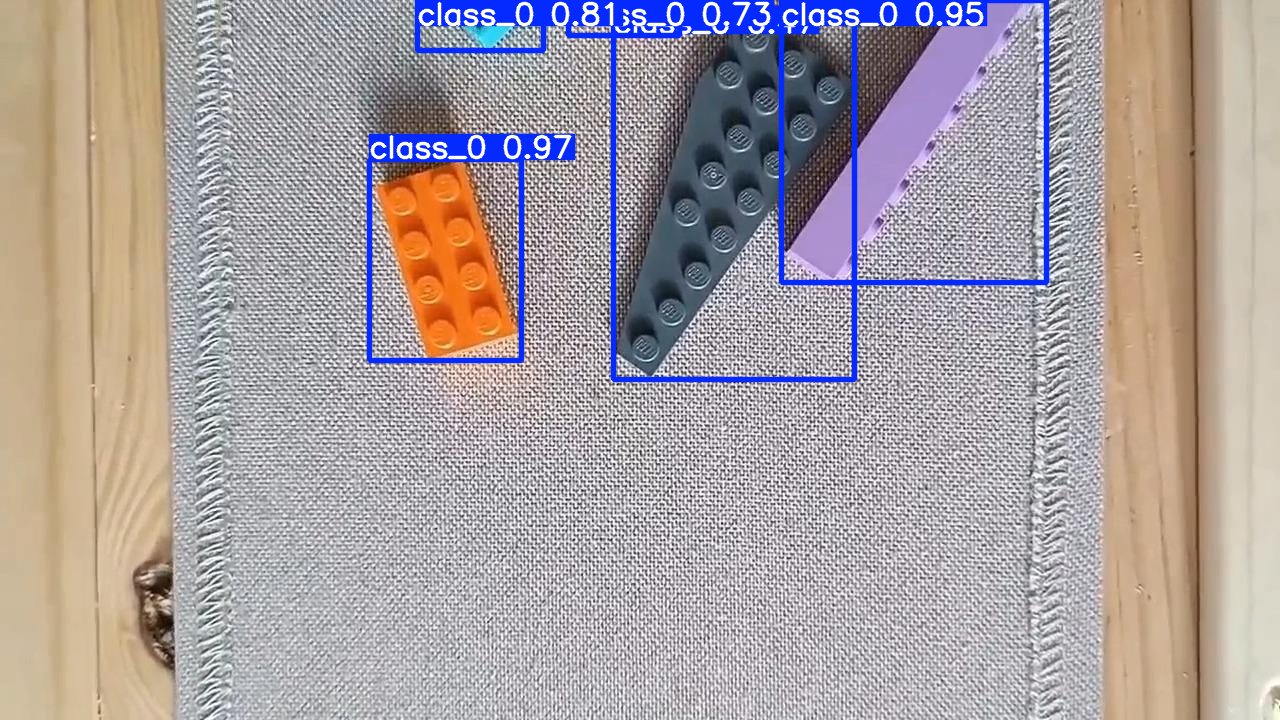

In [12]:
img_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/img1"
example = os.path.join(img_path, "frame0091.jpg")
res = model_ft(example)

detections = res[0]

for box in detections.boxes:
    conf = box.conf[0]  # Get the confidence score
    print(f"Confidence: {conf:.2f}")

rgb_array = cv2.cvtColor(res[0].plot(), cv2.COLOR_BGR2RGB)
image = Image.fromarray(rgb_array)
im = image.convert("RGB")
im

## Test Video Results

In [13]:
base_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test"
test_videos = os.listdir(base_path)
test_videos.sort()
test_videos

['Lego1', 'Lego2']

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [15]:
def detect_and_track(train_video, model, tracker, pred_conf, fps = 20.0):
    video_frames = os.path.join(base_path, f"{train_video}/img1")

    ###################### To record the video
    first_frame_path = os.path.join(video_frames, 'frame0001.jpg')
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width = first_frame.shape[:2]

    video_output = os.path.join('/content/', f'{train_video}_tracked.mp4')
    video_writer = cv2.VideoWriter(video_output, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    ######################

    tracking_results = []
    unique_track_ids = set()
    frames = os.listdir(video_frames)
    frame_pattern = re.compile(r'frame(\d+)\.jpg')
    frames_sorted = sorted(frames, key=lambda x: int(frame_pattern.match(x).group(1)))

    tracker_initialized = False
    for frame_id, frame_name in enumerate(frames_sorted):
        frame_path = os.path.join(video_frames, frame_name)
        frame = cv2.imread(frame_path)

        result_frame = model(frame, conf=pred_conf)
        detections = result_frame[0].boxes.xywh.tolist()
        confidences = result_frame[0].boxes.conf.tolist()


        # Prepare detections in the format required by DeepSort
        formatted_detections = []
        for (x_center, y_center, width, height), conf in zip(detections, confidences):
            left = x_center - width / 2
            top = y_center - height / 2
            formatted_detections.append(([left, top, width, height], conf, 0))

        if not tracker_initialized and len(formatted_detections) > 0:
            tracker_initialized = True
        if len(formatted_detections) > 0:
            tracks = tracker.update_tracks(formatted_detections, frame=frame)
        else:
            tracks = []
        current_frame_object_count = 0

        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            current_frame_object_count += 1
            unique_track_ids.add(track_id)
            tracking_results.append([frame_id, int(track_id), x1, y1, x2 - x1, y2 - y1])

        cv2.putText(frame, f"Objects in frame: {current_frame_object_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Unique objects: {len(unique_track_ids)}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        video_writer.write(frame)

    video_writer.release()
    return tracking_results

In [16]:
path_rtdetr_pt = "lego-tracking/Best_RT-DETR_PT_parameters/Best_RT-DETR_PT_parameters/"
model = RTDETR(path_rtdetr_pt + "best.pt").to(device)
test_frames = [20, 25]

tracking_results_dict = {}
for test_video, test_frame in zip(test_videos, test_frames):
    print(5*"-------------------------------------------------------------------------------------------------------\n")
    print(test_video)
    tracker = DeepSort(max_age=10, n_init=3, nms_max_overlap=1.0)
    test_res = detect_and_track(test_video, model, tracker, 0.25, float(test_frame))
    tracking_results_dict[test_video] = test_res

Streaming output truncated to the last 5000 lines.
Speed: 14.0ms preprocess, 77.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 class_0s, 77.3ms
Speed: 4.1ms preprocess, 77.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 class_0s, 85.9ms
Speed: 11.6ms preprocess, 85.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 class_0s, 79.0ms
Speed: 4.4ms preprocess, 79.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 class_0s, 81.6ms
Speed: 7.2ms preprocess, 81.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 class_0s, 77.6ms
Speed: 3.9ms preprocess, 77.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 class_0s, 78.2ms
Speed: 3.8ms preprocess, 78.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 class_0s, 80.0ms
Speed: 3.9ms preprocess, 80.0ms inference, 0.8ms po

## Metrics

In [17]:
!pip install motmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 6.5 MB/s eta 0:00:00


In [18]:
import motmetrics as mm

In [19]:
def load_ground_truth(gt_file):
    ground_truths = []
    with open(gt_file, 'r') as file:
        for line in file:
            parts = list(map(float, line.strip().split(',')))
            frame_id, obj_id, x, y, width, height = int(parts[0]), int(parts[1]), parts[2], parts[3], parts[4], parts[5]
            ground_truths.append([frame_id, obj_id, x, y, width, height])
    return np.array(ground_truths)

In [20]:
def evaluate_tracking(ground_truths, tracking_results):
    def results_to_motchallenge_format(results):
        return np.array([[r[0], -1, r[2], r[3], r[4], r[5], 1, -1, -1, -1] for r in results])

    gt_mot = results_to_motchallenge_format(ground_truths)
    tr_mot = results_to_motchallenge_format(tracking_results)

    acc = mm.MOTAccumulator(auto_id=True)

    gt_dict = {frame_id: [] for frame_id in np.unique(ground_truths[:, 0])}
    for gt in gt_mot:
        gt_dict[gt[0]].append(gt[1:])

    tr_dict = {frame_id: [] for frame_id in np.unique(tracking_results[:, 0])}
    for tr in tr_mot:
        tr_dict[tr[0]].append(tr[1:])

    for frame_id in gt_dict.keys():
        gt_frame = gt_dict[frame_id]
        tr_frame = tr_dict.get(frame_id, [])

        gt_ids = [gt[0] for gt in gt_frame]
        tr_ids = [tr[0] for tr in tr_frame]

        gt_bboxes = np.array([gt[1:5] for gt in gt_frame])
        tr_bboxes = np.array([tr[1:5] for tr in tr_frame])

        distances = mm.distances.iou_matrix(gt_bboxes, tr_bboxes, max_iou=1)

        acc.update(gt_ids, tr_ids, distances)

    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches'])

    strsummary = mm.io.render_summary(summary, formatters=mh.formatters)
    print(strsummary)

    return summary

## Results

In [21]:
def aggregate_metrics(gt_files, tracking_results_dict):
    overall_acc = mm.MOTAccumulator(auto_id=True)

    dct = {}
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches']

    for gt_file, track_key in zip(gt_files, tracking_results_dict):
        print(gt_file, track_key)
        ground_truths = load_ground_truth(gt_file)
        tr_mot = np.array(tracking_results_dict[track_key])

        et = evaluate_tracking(ground_truths, tr_mot)
        for metric in metrics:
            dct[metric] = dct.get(metric, 0) + et[metric]


    for metric in metrics:
        dct[metric] /= len(gt_files)
    return pd.DataFrame(dct)

In [22]:
main_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test"
gt_files = [os.path.join(main_path, vid, "gt.txt") for vid in os.listdir(main_path)]
gt_files.sort()
gt_files

['/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/gt.txt',
 '/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego2/gt.txt']

In [23]:
sorted_dict = dict(sorted(tracking_results_dict.items()))
print(sorted_dict)

{'Lego1': [[18, 1, 495, -1, 146, 10], [18, 2, 521, -2, 214, 17], [19, 1, 453, -1, 185, 13], [19, 2, 502, -3, 252, 21], [20, 1, 401, -2, 267, 20], [20, 2, 483, -3, 290, 24], [20, 3, 543, 0, 148, 32], [20, 4, 400, -1, 148, 20], [20, 5, 567, -3, 116, 34], [20, 6, 579, 1, 100, 32], [20, 7, 373, -3, 166, 17], [20, 8, 580, -3, 93, 33], [20, 9, 571, -2, 96, 33], [21, 1, 348, -2, 320, 24], [21, 2, 464, -4, 327, 27], [21, 3, 535, 0, 160, 34], [21, 4, 384, 0, 180, 24], [21, 5, 559, -4, 126, 37], [21, 6, 581, 0, 113, 37], [21, 7, 361, -3, 199, 20], [21, 8, 573, -4, 101, 36], [21, 9, 561, -2, 103, 36], [21, 10, 409, 0, 107, 26], [21, 11, 430, -1, 91, 27], [21, 12, 411, 0, 118, 26], [21, 13, 416, -1, 107, 27], [22, 1, 315, -2, 352, 26], [22, 2, 445, -4, 365, 30], [22, 3, 526, 0, 173, 37], [22, 4, 375, 0, 200, 27], [22, 5, 551, -5, 137, 40], [22, 6, 577, 0, 138, 44], [22, 7, 352, -4, 221, 24], [22, 8, 567, -5, 109, 40], [22, 9, 551, -3, 110, 39], [22, 10, 398, 0, 129, 32], [22, 11, 429, -1, 98, 29],

In [24]:
aggregate_metrics(gt_files, sorted_dict) # (max_age=10, n_init=5, nms_max_overlap=1.0)

/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego1/gt.txt Lego1
   mota  motp   idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 84.2% 0.892 935.8%  99.6%     86.6%       10628       10585                1634         43            0
/content/lego-tracking/Lego_Tracking/Lego_Tracking/Test/Lego2/gt.txt Lego2
   mota  motp    idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 89.9% 0.630 1073.5%  96.4%     93.7%       12601       12149                 815        452            0


,mota,motp,idf1,recall,precision,num_objects,num_matches,num_false_positives,num_misses,num_switches
0,0.870831,0.761026,10.046324,0.980042,0.901704,11614.5,11367.0,1224.5,247.5,0.0


## Train Video Results
####  Same steps are applied for training but the folders and files correctly must be defined

In [ ]:
base_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Train"
train_videos = os.listdir(base_path)
train_videos.sort()
train_videos = train_videos[:1] + train_videos[2:] + train_videos[1:2]
train_videos

In [ ]:
path_rtdetr_pt = "lego-tracking/Best_RT-DETR_PT_parameters/Best_RT-DETR_PT_parameters/"
model = RTDETR(path_rtdetr_pt + "best.pt").to(device)  # or '+ last.pt' for development
train_frames = [16, 13, 20, 20, 21, 20, 15, 13, 19, 20]

tracking_results_dict = {}
for train_video, train_frame in zip(train_videos, train_frames):
    print(5*"-------------------------------------------------------------------------------------------------------\n")
    print(train_video)
    tracker = DeepSort(max_age=20, n_init=5, nms_max_overlap=0.8)
    tr_res = detect_and_track(train_video, model, tracker, 0.25, float(train_frame))
    tracking_results_dict[train_video] = tr_res

In [ ]:
main_path = "/content/lego-tracking/Lego_Tracking/Lego_Tracking/Train"
gt_files = [os.path.join(main_path, vid, "gt.txt") for vid in os.listdir(main_path)]
gt_files.sort()
gt_files

In [ ]:
sorted_dict = dict(sorted(tracking_results_dict.items()))
print(sorted_dict)

In [ ]:
aggregate_metrics(gt_files, sorted_dict) # (max_age=10, n_init=5, nms_max_overlap=1.0)